In [1]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 6.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.impute import SimpleImputer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import json
import functools

import pickle  # Added for data storage
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from PIL import Image
from torch.utils.data import Dataset, DataLoader, IterableDataset
import torch.nn as nn
import torchvision
import torch
from sklearn.model_selection import train_test_split
from multiprocessing import Pool
from torchmetrics.functional import pearson_corrcoef
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
path = "/content/drive/MyDrive/RS/ContrastiveLearning/20 epochs 500 dim 0.0001 lr"
# with open(path + '/model.pth', 'rb') as f:
#     model = pickle.load(f)

with open(path + '/foreign_city_embeddings_20ep_500.pickle', 'rb') as f:
    foreign_embeddings_dict = pickle.load(f)

with open(path + '/indian_city_embeddings_20ep_500.pickle', 'rb') as f:
    indian_embeddings_dict = pickle.load(f)

datapath = "/content/drive/MyDrive/RS/Input/"
with open(datapath + 'indian_city_data.json', "r", encoding="utf-8") as f:
    data = json.load(f)
indian_df = pd.DataFrame(data)

with open(datapath + 'foreign_city_data.json', "r", encoding="utf-8") as f:
    data = json.load(f)
foreign_df = pd.DataFrame(data)

In [5]:
# Preprocess text descriptions
def preprocess_text(text):
    text = text.lower()  # Lowercase
    pattern = r'\((?!(mw-parser-output|English|Bengali pronunciation|Kannada pronunciation|IPA|Gujarati|Hindi))[^)]+\)'
    text = re.sub(pattern, '', text)
    text = re.sub(r'[^\w\s]', '', text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    words = word_tokenize(text)
    filtered_text = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    text = ' '.join(filtered_text)

    return text

In [6]:
def compute_similarity(embedding1, embedding2):
    """Calculates the cosine similarity between two embeddings.

    Args:
        embedding1: A torch.Tensor representing the first embedding.
        embedding2: A torch.Tensor representing the second embedding.

    Returns:
        A float representing the cosine similarity between the two embeddings.
    """
    similarity = pearson_corrcoef(embedding1, embedding2)
    # Access the first element (scalar value) of the tensor
    return similarity.item()


In [7]:
def find_top_similar_cities(indian_embedding, european_embeddings, european_city_names, top_k=5):
    """Finds the top K most similar European cities to a given Indian city based on embedding similarity.

    Args:
        indian_embedding: A torch.Tensor representing the embedding of the Indian city.
        european_embeddings: A torch.Tensor containing the embeddings of all European cities.
        european_city_names: A list of strings containing the names of all European cities.
        top_k: An integer specifying the number of top similar cities to return (default: 5).

    Returns:
        A list of tuples containing (city_name, similarity) for the top K most similar European cities.
    """
    similarities = []
    #indian_embedding = indian_embedding.to(device)
    for i, european_embedding in enumerate(european_embeddings):
        #european_embedding = european_embedding.to(device)

        similarity = compute_similarity(indian_embedding, european_embedding)
        similarities.append((european_city_names[i], similarity))
    similarities.sort(key=lambda x: x[1], reverse=True)  # Sort by similarity (descending)
    return similarities[:top_k]

In [8]:
# Function to calculate word frequencies
def calculate_word_frequencies(text):
    # Tokenize text
    words = text.split()
    # Count word frequencies
    word_freq = Counter(words)
    return word_freq

# Function to generate word cloud
def generate_word_cloud(text, words=50):
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', max_words=words).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [9]:
european_city_embeddings = torch.stack([value for value in foreign_embeddings_dict.values()])  # Convert to tensor on GPU if available
european_city_names = list(foreign_embeddings_dict.keys())

indian_city_embeddings = torch.stack([value for value in indian_embeddings_dict.values()])  # Convert to tensor on GPU if available
indian_city_names = list(indian_embeddings_dict.keys())

**Indian-Indian city similarity**

In [10]:
for indian_city, indian_embedding in indian_embeddings_dict.items():
  top_similar_cities = find_top_similar_cities(indian_embedding, indian_city_embeddings, indian_city_names)
  print(f"City: {indian_city}")
  for city_name, similarity in top_similar_cities:
    print(f"\t- {city_name}: {similarity:.4f}")  # Format similarity to 4 decimal places

City: Mumbai
	- Mumbai: 1.0000
	- Kolkata: 0.8754
	- Visakhapatnam: 0.8714
	- Kozhikode: 0.8687
	- Bihar_Sharif: 0.8679
City: Pune
	- Pune: 1.0000
	- Bulandshahr: 0.8728
	- Unnao: 0.8665
	- Lucknow: 0.8647
	- Cuttack: 0.8577
City: Ahmedabad
	- Ahmedabad: 1.0000
	- Hyderabad: 0.8958
	- Surat: 0.8915
	- Nagpur: 0.8821
	- Bihar_Sharif: 0.8817
City: Surat
	- Surat: 1.0000
	- Nagpur: 0.9065
	- Ahmedabad: 0.8915
	- Visakhapatnam: 0.8888
	- Indore: 0.8827
City: Hyderabad
	- Hyderabad: 1.0000
	- Ahmedabad: 0.8958
	- Secunderabad: 0.8860
	- Delhi: 0.8856
	- Kolkata: 0.8832
City: Delhi
	- Delhi: 1.0000
	- Bareilly: 0.9032
	- Prayagraj: 0.8976
	- Gwalior: 0.8942
	- Kolkata: 0.8926
City: Chennai
	- Chennai: 1.0000
	- Visakhapatnam: 0.9184
	- Nagpur: 0.9038
	- Thiruvananthapuram: 0.9005
	- Kochi: 0.8843
City: Bangalore
	- Bangalore: 1.0000
	- Mangalore: 0.9127
	- Bareilly: 0.8926
	- Nagpur: 0.8902
	- Prayagraj: 0.8895
City: Kolkata
	- Kolkata: 1.0000
	- Visakhapatnam: 0.8938
	- Delhi: 0.8926
	- Hyd

**European-European city similarity**

In [11]:
for foreign_city, foreign_embedding in foreign_embeddings_dict.items():
  top_similar_cities = find_top_similar_cities(foreign_embedding, european_city_embeddings, european_city_names)
  print(f"City: {foreign_city}")
  for city_name, similarity in top_similar_cities:
    print(f"\t- {city_name}: {similarity:.4f}")

City: Paris
	- Paris: 1.0000
	- Bordeaux: 0.9098
	- Marseille: 0.8780
	- Toulouse: 0.8666
	- Lille: 0.8631
City: Ruhr
	- Ruhr: 1.0000
	- Essen: 0.8803
	- Linz: 0.8578
	- Erlangen: 0.8549
	- Düsseldorf: 0.8444
City: Rome
	- Rome: 1.0000
	- Naples: 0.9124
	- Bologna: 0.9005
	- Milan: 0.8990
	- Como: 0.8973
City: Athens
	- Athens: 1.0000
	- Amsterdam: 0.8706
	- Thessaloniki: 0.8688
	- Rome: 0.8628
	- Naples: 0.8504
City: Naples
	- Naples: 1.0000
	- Rome: 0.9124
	- Como: 0.9039
	- Milan: 0.9025
	- Genoa: 0.9010
City: Milan
	- Milan: 1.0000
	- Turin: 0.9069
	- Naples: 0.9025
	- Rome: 0.8990
	- Bologna: 0.8891
City: Madrid
	- Madrid: 1.0000
	- Turin: 0.8832
	- Igualada: 0.8804
	- Marvão: 0.8766
	- Cáceres: 0.8759
City: Berlin
	- Berlin: 1.0000
	- Hamburg: 0.8865
	- Nuremberg: 0.8768
	- Munich: 0.8768
	- Mannheim: 0.8696
City: Lisbon
	- Lisbon: 1.0000
	- Porto: 0.8781
	- Genoa: 0.8577
	- Bilbao: 0.8562
	- Barcelona: 0.8552
City: Stockholm
	- Stockholm: 1.0000
	- Copenhagen: 0.8648
	- Amsterda

**Indian-European city similarity with Word cloud**

In [12]:
for indian_city, indian_embedding in indian_embeddings_dict.items():
    print(f"City: {indian_city}")
    india_city_row = indian_df[indian_df['city'] == indian_city].iloc[0]  # Retrieve the row corresponding to the European city
    india_city_text = india_city_row['paragraphs']  # Extract text from the 'paragraphs' column
    india_city_text = preprocess_text(india_city_text)
    # Calculate word frequencies
    word_freq = calculate_word_frequencies(india_city_text)
    # Print the most common words in the European city's text
    # print("Most common words in", indian_city, ":")
    # for word, freq in word_freq.most_common(10):  # Print top 10 most common words
    #     print(word, ":", freq)

    # Generate word cloud for the European city's text
    #generate_word_cloud(india_city_text)
    #print()

    top_similar_cities = find_top_similar_cities(indian_embedding, european_city_embeddings, european_city_names, 5)
    for city_name, similarity in top_similar_cities:
        print(f"\t- {city_name}: {similarity:.4f}")  # Format similarity to 4 decimal places

    # for city_name, similarity in top_similar_cities[:1]:
    #     print(f"- {city_name}: {similarity:.4f}")  # Format similarity to 4 decimal places
    #     euro_city_row = foreign_df[foreign_df['city'] == city_name].iloc[0]  # Retrieve the row corresponding to the European city
    #     euro_city_text = euro_city_row['paragraphs']  # Extract text from the 'paragraphs' column
    #     euro_city_text = preprocess_text(euro_city_text)
    #     # Calculate word frequencies
    #     word_freq = calculate_word_frequencies(euro_city_text)
    #     # Print the most common words in the European city's text
    #     # print("Most common words in", city_name, ":")
    #     # for word, freq in word_freq.most_common(10):  # Print top 10 most common words
    #     #     print(word, ":", freq)

    #     # Generate word cloud for the European city's text
    #     generate_word_cloud(euro_city_text)
    #     print()
    #     print()


City: Mumbai
	- Budapest: 0.8210
	- Manchester: 0.8023
	- Birmingham: 0.8022
	- Rome: 0.7997
	- Barcelona: 0.7971
City: Pune
	- Szeged: 0.7920
	- Toledo: 0.7845
	- Székesfehérvár: 0.7844
	- Prague: 0.7831
	- Pleven: 0.7809
City: Ahmedabad
	- Budapest: 0.7945
	- Amsterdam: 0.7859
	- Seville: 0.7797
	- Zaragoza: 0.7777
	- Córdoba: 0.7717
City: Surat
	- Bilbao: 0.7875
	- Budapest: 0.7867
	- Amsterdam: 0.7822
	- Rotterdam: 0.7790
	- Bucharest: 0.7711
City: Hyderabad
	- Budapest: 0.8124
	- Leeds: 0.7880
	- Delft: 0.7851
	- Amsterdam: 0.7804
	- Sheffield: 0.7793
City: Delhi
	- Toledo: 0.8113
	- Budapest: 0.8037
	- Pleven: 0.7975
	- Durham: 0.7970
	- Foggia: 0.7963
City: Chennai
	- Leeds: 0.8083
	- Amsterdam: 0.8081
	- Manchester: 0.7992
	- London: 0.7895
	- Sheffield: 0.7877
City: Bangalore
	- Foggia: 0.7870
	- Bologna: 0.7825
	- Bilbao: 0.7745
	- Évora: 0.7737
	- Barcelona: 0.7711
City: Kolkata
	- Budapest: 0.8261
	- Birmingham: 0.8134
	- Amsterdam: 0.8134
	- Leeds: 0.8017
	- Barcelona: 0.8

**Visualization using PCA, t-SNE**

In [13]:
# Convert dictionaries to dataframes
def convert_dict_to_df(indian_embeddings_dict, foreign_embeddings_dict):
    df_indian = pd.DataFrame.from_dict(indian_embeddings_dict, orient='index')
    df_european = pd.DataFrame.from_dict(foreign_embeddings_dict, orient='index')

    # Add labels to dataframes
    df_indian['label'] = 'Indian City'
    df_european['label'] = 'European City'

    # Concatenate dataframes
    df_X = pd.concat([df_indian, df_european], ignore_index=True)

    # Create dataframe for labels
    df_Y = pd.DataFrame(df_X['label'])

    # Drop label column from df_X
    df_X.drop(columns=['label'], inplace=True)


    # Impute missing values with mean
    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(df_X)

    # Convert dataframes to numpy arrays
    X = df_X.to_numpy()
    Y = df_Y.to_numpy().flatten()

    return X, Y


In [14]:
from sklearn.decomposition import PCA
# Apply PCA for dimensionality reduction to 2 dimensions
def apply_PCA(X, Y, num_dimensions=2):
    pca = PCA(n_components=num_dimensions)
    X_pca = pca.fit_transform(X)

    # Scatter plot of embeddings with color based on labels
    plt.figure(figsize=(10, 8))
    for label in np.unique(Y):
        plt.scatter(X_pca[Y == label, 0], X_pca[Y == label, 1], label=label)
    plt.title('PCA Visualization of City Embeddings')
    plt.xlabel('PCA Dimension 1')
    plt.ylabel('PCA Dimension 2')
    plt.legend()
    plt.show()

In [15]:
# Apply t-SNE for dimensionality reduction
def apply_tSNE(X, Y):
    tsne = TSNE(n_components=2, perplexity=20, random_state=42)
    X_embedded = tsne.fit_transform(X)

    # Scatter plot of embeddings with color based on labels
    plt.figure(figsize=(10, 8))
    for label in np.unique(Y):
        plt.scatter(X_embedded[Y == label, 0], X_embedded[Y == label, 1], label=label)
    plt.title('t-SNE Visualization of City Embeddings')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend()
    plt.show()

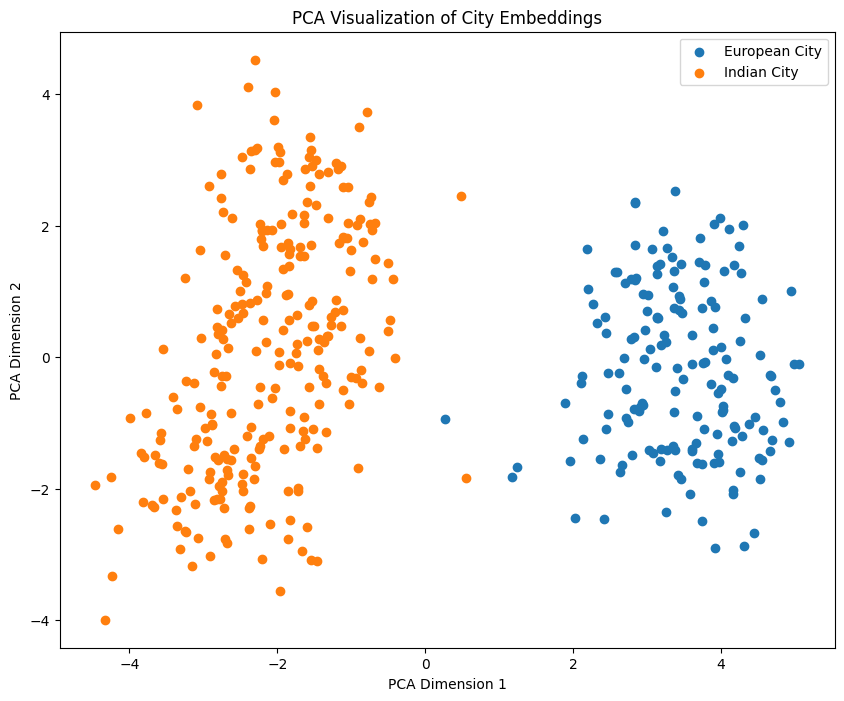

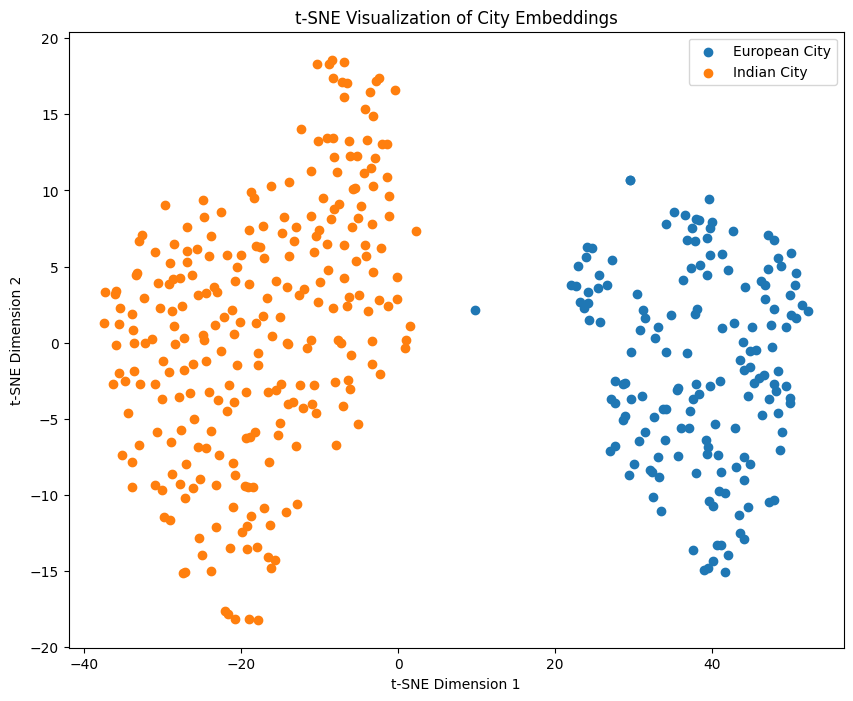

In [16]:
X, Y = convert_dict_to_df(indian_embeddings_dict, foreign_embeddings_dict)
apply_PCA(X, Y)
print()
print()
apply_tSNE(X, Y)

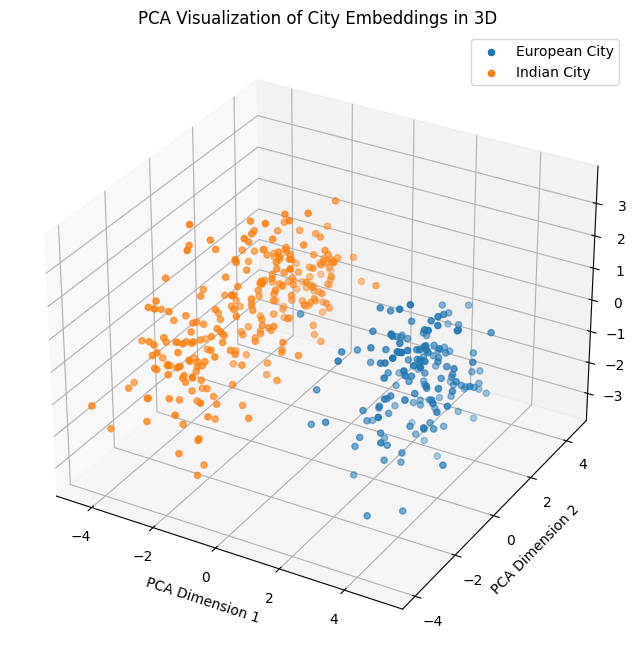

In [17]:
from sklearn.decomposition import PCA
# Apply PCA for dimensionality reduction to 3 dimensions
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of embeddings with color based on labels
for label in np.unique(Y):
    ax.scatter(X_pca[Y == label, 0], X_pca[Y == label, 1], X_pca[Y == label, 2], label=label)

ax.set_title('PCA Visualization of City Embeddings in 3D')
ax.set_xlabel('PCA Dimension 1')
ax.set_ylabel('PCA Dimension 2')
ax.set_zlabel('PCA Dimension 3')
ax.legend()

plt.show()